In [1]:
# LIST OF UPDATES
#
# Added bias (constant) to each linear layer
# Switched to using equivalent keras optimizer - SGD 
# Moved loss calculation to an independent function
# Switched to defining the network as Keras layers(!)
# Add tf.function to training loop - 10x speed increase(!)
# Switch to calculating gradients with keras 'trainable_weight' vs tf 'variables' 
# Tried using Keras Model.fit but order of magnitude slower than custom loop!
# Switch to train/val/test -> Showed that validation accuracy peaks at about 55% Training accuracy :(
# Switch to MeanSquaredError as loss function (But this is not a good error for classification)
# Add callback support to custom training loop
# Early completion based on validation changes
# Switch to correct method of regularisation with L2 Loss
# Addition of Dropout for regularisation
# Batch support (improves regularisation)
# Tried various train/test/val combinations - results are very sensitive to this.
# Tried various activation functions - "elu" seems best (not sure why yet)
# Switched to BinaryCrossEntropy loss function from keras
# Switched to Adam optimiser with scheduled learning
# Utilised log x-scale to compare model plot results
# Switch to "relu" activation function on hidden nodes - good for variables in 0 to 1 range.
# Add Accuracy as a metric
# Add multiple plots to compare metrics
# Switch to Hinge loss function- better for penalising wrong sign!
# Switch to tanh activation function and -1/1 labels (for Hinge)
# Initialise variables with "he-uniform" - better for relu?
# Regularisation after the activiation function, using Lamda to control how much impact.
# TODO : Represent data using windowing method


In [1]:
import tensorflow as tf
import tensorflow.compat.v1 as tf1

import numpy as np
import pandas as pd
import time

import quantutils.dataset.pipeline as ppl
import quantutils.dataset.ml as mlutils
from marketinsights.api.model import MarketInsightsModel
from marketinsights.api.aggregator import MarketDataAggregator
from marketinsights.remote.ml import MIAssembly

from tqdm import tqdm, trange
from functools import partialmethod

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
from matplotlib import pyplot as plt


tqdm.__init__ = partialmethod(tqdm.__init__, disable=False)

2023-05-31 22:27:16.528963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 22:27:17.092064: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-31 22:27:17.092124: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-31 22:27:19.212276: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
data_config = [
    {
        "ID": "MDS",
        "class": "MDSConnector",
        "opts": {
            "location": "http://pricestore.192.168.1.203.nip.io"
        },
        "timezone": "UTC",
        "markets": [
            {
                "ID": "DOW",
                "sources": [
                    {
                        "ID": "WallSt-hourly",
                        "sample_unit": "H"
                    },
                    {
                        "ID": "D&J-IND",
                        "sample_unit": "5min"
                    }
                ]
            },
            {
                "ID": "SPY",
                "sources": [
                    {
                        "ID":"SP500-hourly",
                        "sample_unit":"H"
                    },
                    {
                        "ID":"SANDP-500",
                        "sample_unit":"5min"
                    }
                ]
            }
        ]
    }
]


## Get Market Data
aggregator = MarketDataAggregator(data_config)
   
start = "2013-01-02" # Train period
#end = "2023-08-01" 
end = "2018-08-02"

dataset = aggregator.getData(mkts=["DOW"], sample_unit="H", start=start, end=end, aggregate=True, debug=False).xs("DOW")


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.70s/it]


In [10]:
df = dataset[:]
df

,Open,High,Low,Close
Date_Time,,,,
2013-01-02 05:00:00+00:00,13104.14,13104.14,13104.14,13104.14
2013-01-02 14:00:00+00:00,13104.30,13368.62,13104.30,13366.42
2013-01-02 15:00:00+00:00,13366.48,13374.82,13338.68,13345.45
2013-01-02 16:00:00+00:00,13345.60,13353.75,13321.64,13321.77
2013-01-02 17:00:00+00:00,13321.76,13339.25,13320.28,13326.66
...,...,...,...,...
2018-08-02 18:00:00+00:00,25347.50,25361.50,25312.50,25324.50
2018-08-02 19:00:00+00:00,25324.00,25350.50,25304.50,25329.50
2018-08-02 20:00:00+00:00,25329.00,25361.50,25327.00,25353.50


In [72]:
WINDOW_SIZE = 2 + 1

df = dataset[:]
df = ppl.localize(df, "UTC", "US/Eastern")
df = ppl.cropTime(df, "09:00", "16:00")

# Log prices, differenced from previous Close
df = np.log(df)

# REMOVE ERROR CASES FOR INCORRECT CROP TIME
# Extract Date and Time values
x = df.reset_index().assign(Date=lambda x: pd.to_datetime(x['Date_Time']).dt.date).assign(Time=lambda x: pd.to_datetime(x['Date_Time']).dt.time)
# Count Time entries per day
a = x.groupby('Date')['Time'].nunique() 
# Remove days where Time count is not correct, and reset index back to normal
df = x[~x["Date"].isin(a[a != WINDOW_SIZE].index)].set_index("Date_Time").drop(columns=["Date", "Time"])

#diff = df["Close"] - df["Open"]
df = normaliseCandlesticks(df, allowZero=False) 

df["Direction"] = encode(df, "binary", negative=-1)

# Now encoded in the range - so drop High/Low
#df = df.drop(columns=["High", "Low"])

train_df = df[:WINDOW_SIZE * 1200]
val_df = df[WINDOW_SIZE * 1200:WINDOW_SIZE * 1300]
test_df = df[WINDOW_SIZE * 1300:]

df.head()

,Open,High,Low,Close,Range,Direction
Date_Time,,,,,,
2013-01-02 09:00:00-05:00,-1.000000,1.0,-1.0,0.983517,0.599092,1.0
2013-01-02 10:00:00-05:00,0.538942,1.0,-1.0,-0.624934,0.081172,-1.0
2013-01-02 11:00:00-05:00,0.492826,1.0,-1.0,-0.991893,0.072224,-1.0
2013-01-02 12:00:00-05:00,-0.843862,1.0,-1.0,-0.327041,0.042694,1.0
2013-01-02 13:00:00-05:00,-0.390190,1.0,-1.0,-0.013768,0.030497,1.0


In [73]:
##
# Encode classification
##


def encode(data, encoding, negative=0):
    nanIndex = data.isnull().any(axis=1)
    if encoding == "binary":
        # Is close (index -1) higher that open (index 0)
        df = pandas.DataFrame(
            (data["Close"] > data["Open"]).astype(float), data.index
        )
    elif encoding == "one-hot":
        df = pandas.DataFrame(
            numpy.column_stack(
                [
                    (data["Close"] > data["Open"]).astype(float),
                    (data["Open"] > data["Close"]).astype(float),
                ]
            ),
            data.index,
        )
    
    df[df==0] = negative
    df.values[nanIndex.values] = numpy.nan

    return df

import numpy 
import pandas 

def normaliseCandlesticks(data, allowZero=True):
    X = data.values
    Xmax = X.max(axis=1)[numpy.newaxis].T
    Xmin = X.min(axis=1)[numpy.newaxis].T
    range = Xmax - Xmin
    X = (X - Xmin) / range
    if not allowZero:
        X = (X * 2) - 1

    # Feature to reflect the range as a percent of the Open price for that period.

    # Calibrated to provide a normalised range percent between 0 and 1 (for logged prices)
    # TODO: These are log prices so this should just be the log diff between close and open?
    RANGE_CONSTANT = 30
    #range_pct = range.T * RANGE_CONSTANT / data.iloc[:,0].values
    range_pct = range.T * RANGE_CONSTANT
    return pandas.DataFrame(
        numpy.hstack((X, numpy.column_stack(range_pct))), data.index, columns=["Open","High","Low","Close","Range"]
    )

In [74]:
class WindowGenerator():
    
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None, batch_size=32):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size=batch_size

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def make_dataset(self, data, batch_size=32):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=self.total_window_size,
          shuffle=False,
          batch_size=batch_size)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df, batch_size=self.batch_size)

    @property
    def val(self):
        return self.make_dataset(self.val_df, batch_size=self.batch_size)

    @property
    def test(self):
        return self.make_dataset(self.test_df, batch_size=self.batch_size)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def plot(self, model=None, plot_col='Direction', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time')

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [75]:
w1 = WindowGenerator(input_width=WINDOW_SIZE-1, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=['Direction'], batch_size=40)

for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (40, 6, 6)
Labels shape (batch, time, features): (40, 1, 1)


In [76]:
train_df_x, train_df_y = dataset_to_tensor(w1.train)
val_df_x, val_df_y = dataset_to_tensor(w1.val)
test_df_x, test_df_y = dataset_to_tensor(w1.test)

In [77]:
def roundTan(x):
    x = tf.where(x < 0, -1., x)
    x = tf.where(x > 0, 1., x)
    return x

def toSigmoid(x):
    return tf.where(x<0, 0., 1.)

def dataset_to_tensor(dataset):
    # Create an empty list to store the numpy arrays
    x = []
    y = []
    
    # Loop through the mapdataset
    for element in dataset:
        # Convert the element to a numpy array and append it to the list
        x.append(element[0].numpy())
        y.append(element[1].numpy())
    
    # Return the list of numpy arrays
    return tf.cast(np.concatenate(x, axis=0), tf.float32), tf.cast(np.concatenate(y, axis=0), tf.float32)


def train(mlmodel, window, epochs=100000, _callbacks=[]):
    
    callbacks = tf.keras.callbacks.CallbackList(_callbacks, add_history=True, model=mlmodel)
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.001,
      decay_steps=1000,
      decay_rate=1,
      staircase=False)

    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SquaredHinge()
    val_loss_fn = tf.keras.metrics.SquaredHinge()
    metric = tf.keras.losses.MeanSquaredError()
    accuracyMetric = tf.keras.metrics.Accuracy()
    val_accuracyMetric = tf.keras.metrics.Accuracy()
    lamda = tf.constant(0.1, tf.float32)
        
    @tf.function  # Make it fast.
    def train_on_batch(x, y):
        with tf.GradientTape() as tape:
            
            loss = loss_fn(y_pred=tf.nn.tanh(mlmodel(x, training=True)), y_true=y) 
            regularization_loss=tf.add_n(mlmodel.losses)
            loss = loss + regularization_loss * lamda
            
            #binary_cross_entropy = metric(y_pred=y_pred, y_true=y) 
            val_model = tf.nn.tanh(mlmodel(val_df_x))
            
            #val_binary_cross_entropy = metric(y_pred=val_y_pred, y_true=val_y)
            val_loss = val_loss_fn(y_pred=val_model, y_true=val_df_y) 
            
            accuracy = accuracyMetric(y_pred=roundTan(mlmodel(x)), y_true=y)
            val_accuracy = val_accuracyMetric(y_pred=roundTan(val_model), y_true=val_df_y)
            
            gradients = tape.gradient(loss, mlmodel.trainable_weights)
                                
        optimizer.apply_gradients(zip(gradients, mlmodel.trainable_weights))
        return {
            "loss":loss, 
            "val_loss": val_loss, 
            #"metric":binary_cross_entropy, 
            #"val_metric":val_binary_cross_entropy, 
            "accuracy": accuracy,
            "val_accuracy": val_accuracy,
            "regularization_loss":regularization_loss}

    logs = {}
    mlmodel.stop_training = False
    
    # Store the start time
    start_time = time.time()

    callbacks.on_train_begin(logs=logs)

    # Format training loop
    for epoch in range(epochs):

        callbacks.on_epoch_begin(epoch, logs=logs)
        #mlmodel.reset_states() # Not needed?

        for batch, (batch_x, batch_y) in enumerate(window.train):

            callbacks.on_batch_begin(batch, logs=logs)
            callbacks.on_train_batch_begin(batch, logs=logs)

            logs = train_on_batch(batch_x, batch_y)

            callbacks.on_train_batch_end(batch, logs=logs)
            callbacks.on_batch_end(batch, logs=logs)

        callbacks.on_epoch_end(epoch, logs=logs)

        if epoch % 100 == 0:
            
            # Store the end time
            end_time = time.time() - start_time
            start_time = time.time()
            
            print(f'Step {epoch} - Training Loss: {logs["loss"]}, Val Loss: {logs["val_loss"]}, Accuracy: {logs["accuracy"]}, Val Accuracy: {logs["val_accuracy"]}, Time: {end_time:.2f} sec')

        if mlmodel.stop_training:
            print(f'Step {epoch} - Training Loss: {logs["loss"]}, Val Loss: {logs["val_loss"]}')
            break

    callbacks.on_train_end(logs=logs)

    # Fetch the history object we normally get from keras.fit
    history_object = None
    for cb in callbacks:
        if isinstance(cb, tf.keras.callbacks.History):
            history_object = cb
    assert history_object is not None
    
    return history_object

In [78]:
TOTAL_EPOCHS = 200000

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, start_from_epoch=500, patience=1000, restore_best_weights=True)
# Set up callbacks
callbacks = [earlyStopping]


In [79]:
histories = {}

In [80]:
NUM_LABELS = 1
HIDDEN_UNITS = 64

conv_layer = tf.keras.layers.Conv1D(
            filters=HIDDEN_UNITS,
            kernel_size=(WINDOW_SIZE-1,),
            kernel_initializer='he_uniform',
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
            activation='relu')

# Prepare our layer, loss, and optimizer.
mlmodel = tf.keras.Sequential(
    [
        # Shape: (time, features) => (time*features)
        conv_layer,
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.8),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_LABELS),
    ]
)

history = train(mlmodel, w1, TOTAL_EPOCHS, callbacks)

print("Done")

Step 0 - Training Loss: 1.762088656425476, Val Loss: 1.4562742710113525, Accuracy: 0.5183333158493042, Val Accuracy: 0.46266666054725647, Time: 2.74 sec
Step 100 - Training Loss: 1.0363191366195679, Val Loss: 1.179305076599121, Accuracy: 0.5256435871124268, Val Accuracy: 0.48649173974990845, Time: 16.47 sec
Step 200 - Training Loss: 1.0224257707595825, Val Loss: 1.0911264419555664, Accuracy: 0.5241459608078003, Val Accuracy: 0.49328356981277466, Time: 16.54 sec
Step 300 - Training Loss: 0.9903656840324402, Val Loss: 1.0610889196395874, Accuracy: 0.5283776521682739, Val Accuracy: 0.5004263520240784, Time: 16.64 sec
Step 400 - Training Loss: 0.9956203699111938, Val Loss: 1.0450725555419922, Accuracy: 0.540820837020874, Val Accuracy: 0.5058878064155579, Time: 16.50 sec
Step 500 - Training Loss: 0.8756106495857239, Val Loss: 1.035237431526184, Accuracy: 0.5544843673706055, Val Accuracy: 0.508190929889679, Time: 16.55 sec
Step 600 - Training Loss: 0.8059036135673523, Val Loss: 1.03241121768

Text(0.5, 0, 'Epochs')

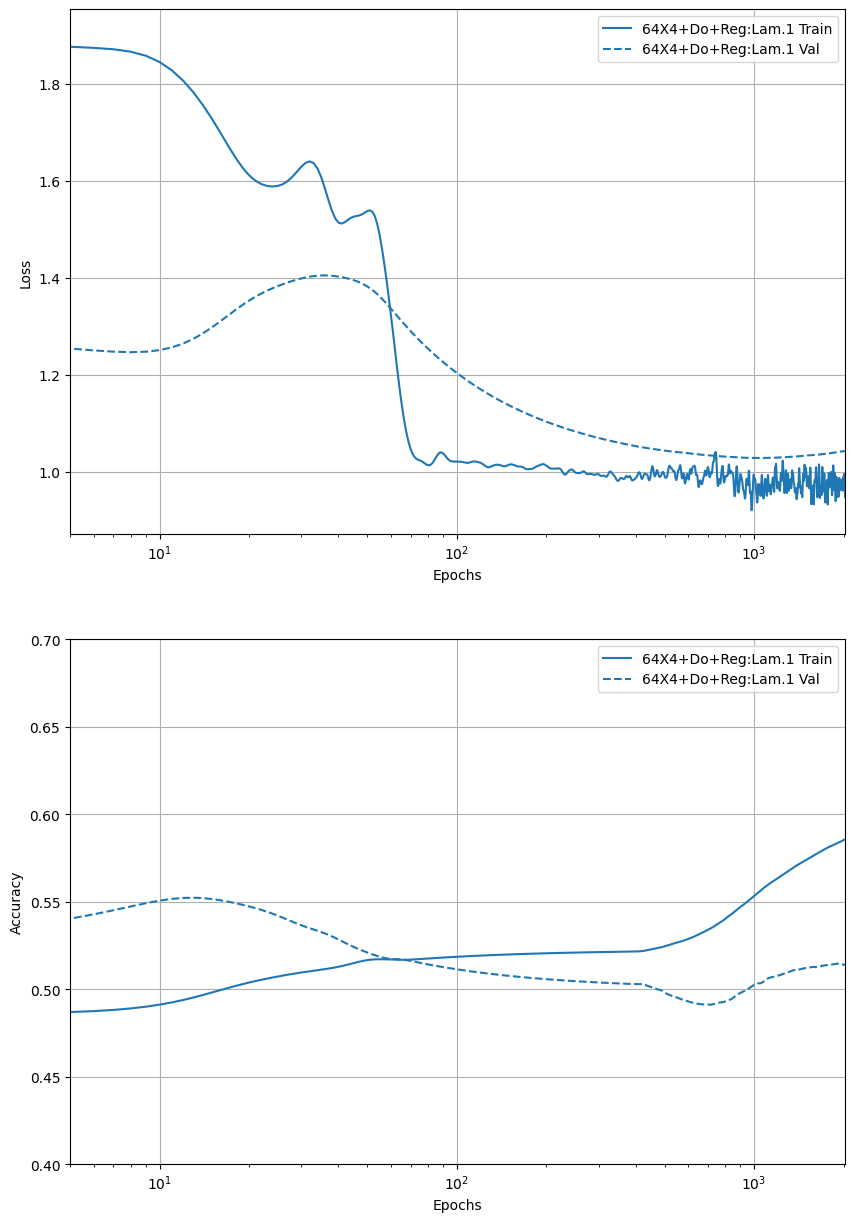

In [60]:
histories["64x4+DO+Reg:Lam.1"] = history

plt.rcParams['figure.figsize'] = [10, 15]

# PLOT histories
plt.subplot(211)
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10).plot(histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
#plt.ylim([0.75, 1.1])
plt.xlabel("Epochs")

plt.subplot(212)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10).plot(histories)
#plotter.plot(histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.4, 0.7])
plt.xlabel("Epochs")


Actual data ratio: 52.25% Positive, 47.75% Negative
Prediction data ratio: 64.92% Positive, 35.08% Negative

Classification Metrics

Won : 752
Lost : 448
Total : 1200
Diff : 304

Accuracy : 62.67%
Information Coefficient (Edge): 25.33%
Expected Value (Annualised): 11585.37%

Precision: Of all the predicted Buys/Sells, how many were correct?
Precision (Buy) : 61.49%
Precision (Sell): 64.85%

Recall: Of all the actual Buys/Sells, how many were correct?
Recall (Buy): 76.40%
Recall (Sell): 47.64%

F1 Score: Harmonic mean of Precision and Recall for the Buys/Sells
F1 Score (Buy): 68.14%
F1 Score (Sell): 54.93%


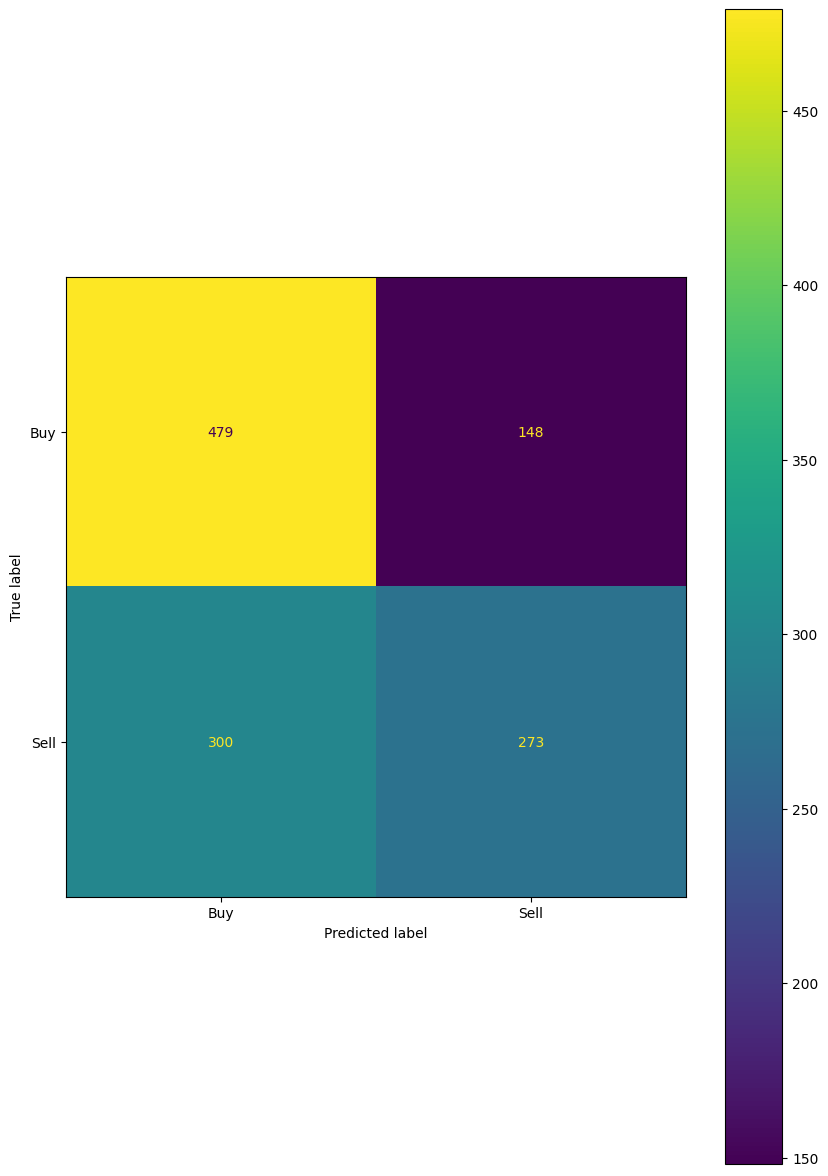

In [61]:
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

pred = pd.DataFrame(roundTan(tf.nn.tanh(mlmodel(train_df_x))).numpy().flatten(), index=dataset.index[:1200])
true = pd.DataFrame(train_df_y.numpy().flatten(), index=dataset.index[:1200])

print(f"Actual data ratio: {len(true.values[true>0])/len(true):.2%} Positive, {len(true.values[true<0])/len(true):.2%} Negative")
print(f"Prediction data ratio: {len(pred.values[pred>0])/len(pred):.2%} Positive, {len(pred.values[pred<0])/len(pred):.2%} Negative")

im = InsightManager(None)
im.addInsightGenerator(im.createInsightGenerator("ConfusionMatrix", opts={"actual":true[0], "predictions":pred[0], "noHold":True, "returnsData":False}))
#im.addInsightGenerator(im.createInsightGenerator("ConfusionMatrix", opts={"baseline":p.assets[0], "noHold":True}))

results = im.generateInsights()


In [31]:
tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_pred=baseline, y_true=toSigmoid(val_y))

<tf.Tensor: shape=(), dtype=float64, numpy=0.6941605066964598>

In [30]:
baseline = [np.sum(toSigmoid(train_y)==1)/len(train_y)]*len(test_y)

In [32]:
tf.keras.metrics.BinaryAccuracy()(y_pred=baseline, y_true=toSigmoid(test_y))

<tf.Tensor: shape=(), dtype=float32, numpy=0.43678162>

In [33]:
tf.keras.metrics.BinaryAccuracy()(y_pred=tf.nn.sigmoid(mlmodel(test_x)), y_true=toSigmoid(test_y))

<tf.Tensor: shape=(), dtype=float32, numpy=0.4827586>